In [1]:
from datasets import load_dataset
import numpy as np
from transformers import DistilBertTokenizerFast, AutoModel, Trainer, TrainingArguments
import seaborn as sns
from dataclasses import dataclass
from typing import List, Union, Dict
import torch

In [2]:
hdfs1_dataset = load_dataset('text', data_files='../data/raw/HDFS1/HDFS.log', split='train')

Using custom data configuration default-3571b23bb2152210
Reusing dataset text (/home/cernypro/.cache/huggingface/datasets/text/default-3571b23bb2152210/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691)


In [3]:
def remove_timestamp(example):
    # need to find third occurence of a space and slice the string after it
    # using a very non robust silly solution
    s = example['text']
    example['text'] = s[s.find(' ', s.find(' ', s.find(' ')+1)+1)+1:]
    return example

cleaned_dataset = hdfs1_dataset.map(remove_timestamp)

Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-3571b23bb2152210/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-15d3de4e024d5591.arrow


In [4]:
pretrained_model_name = "distilbert-base-cased"
tokenizer = DistilBertTokenizerFast.from_pretrained(pretrained_model_name)

In [5]:
small_cleaned_dataset = cleaned_dataset.select(range(20000))

In [6]:
def tokenize_dontpad_dataset(examples, tokenizer):
    return tokenizer(examples['text'], truncation=True, return_special_tokens_mask=True)
# tokenized_unpadded_dataset = cleaned_dataset.map(tokenize_dontpad_dataset, fn_kwargs={'tokenizer': tokenizer}, batched=True, batch_size=1000, remove_columns=['text'])

In [7]:
def tokenize_no_special_tokens(examples, tokenizer):
    return {'tokens': tokenizer(examples['text'], add_special_tokens=False, truncation=True, return_attention_mask=False)['input_ids']}
small_tokenized = small_cleaned_dataset.map(tokenize_no_special_tokens, fn_kwargs={'tokenizer': tokenizer}, batched=True, batch_size=1000)

Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-3571b23bb2152210/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-afd185a41044cef4.arrow


In [8]:
def chunkify(examples):
    return {"chunk": [examples['tokens']]}
chunked = small_tokenized.map(chunkify, batched=True, batch_size=10, drop_last_batch=True, remove_columns=small_tokenized.column_names)

Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-3571b23bb2152210/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-62ba6d1c76d79bf8.arrow


In [9]:
chunked

Dataset({
    features: ['chunk'],
    num_rows: 2000
})

In [10]:
@dataclass
class DataCollatorForInverseClozeTask:
    remove_target_from_context_probability: float = 0.9
    target_max_seq:int = 512
    context_max_seq:int = 512
    start_token:int = 101 # [CLS]
    sep_token:int = 102 # [SEP]
    pad_token:int = 0
        
    def _make_mask(self, padded_batch):
        return (padded_batch != self.pad_token).astype(np.uint8)
        
    def _pad_truncate_add_special_tokens(self, batch: List[List[int]], max_len): 
        sequence_lengths = np.array([min(max_len-2, len(seq)) for seq in batch])
        batch_max_len = sequence_lengths.max()
        padded_batch = np.full(shape=(len(batch), batch_max_len+2), fill_value=self.pad_token, dtype=np.int64)
        padded_batch[:, 0] = self.start_token
        for seq_idx, seq in enumerate(batch):
            padded_batch[seq_idx, 1:sequence_lengths[seq_idx]+1] = seq[:sequence_lengths[seq_idx]]
            padded_batch[seq_idx, sequence_lengths[seq_idx]+1] = self.sep_token
        mask = self._make_mask(padded_batch)
        return torch.from_numpy(padded_batch), torch.from_numpy(mask)
    
    def _create_target_and_flat_contexts_from_contexts(self, contexts: List[List[List[int]]]):
        # TODO: add sep_token between each sentence when flattening context?
        target_sentence_idxs = [torch.randint(low=0, high=len(context), size=(1,)).item() for context in contexts]
        remove_target = [torch.rand(size=(1,)).item() < self.remove_target_from_context_probability for _ in target_sentence_idxs]
        target_sentences = [context[i] for (i, context) in zip(target_sentence_idxs, contexts)]
        processed_contexts = [context[:target_idx] + context[target_idx + remove:] for (target_idx, remove, context) in zip(target_sentence_idxs, remove_target, contexts)]
        flattened_contexts = [[token for sentence in context for token in sentence] for context in processed_contexts]
        return target_sentences, flattened_contexts
             
    def __call__(self, contexts: List[Union[List[List[int]], Dict[str, List[List[int]]]]]):
        if isinstance(contexts[0], dict):
            contexts = [context_dict['chunk'] for context_dict in contexts]
        target_sentences, flattened_contexts = self._create_target_and_flat_contexts_from_contexts(contexts)
        correct_class = torch.tensor(list(range(len(target_sentences))), dtype=torch.int64)
        padded_target_batch, padded_target_mask = self._pad_truncate_add_special_tokens(target_sentences, self.target_max_seq)
        padded_context_batch, padded_context_mask = self._pad_truncate_add_special_tokens(flattened_contexts, self.context_max_seq)
        return {'target': padded_target_batch,
                'target_mask': padded_target_mask,
                'context': padded_context_batch,
                'context_mask': padded_context_mask,
                'correct_class': correct_class}
        
    

In [11]:
data_collator = DataCollatorForInverseClozeTask()

In [12]:
class ClsEncoderTower(torch.nn.Module):
    def __init__(self, pretrained_model_name_or_path, output_encode_dimension=512):
        super(ClsEncoderTower, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name_or_path)
        self.linear = torch.nn.Linear(self.bert.config.dim, output_encode_dimension) # self.bert.config.dim most likely 768
        
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_embedding = bert_output[0][:, 0]
        cls_encoding = self.linear(cls_token_embedding)
        return cls_encoding
        
    

In [13]:
class OneTowerICT(torch.nn.Module):
    def __init__(self, pretrained_model_name_or_path, output_encode_dimension=512):
        super(OneTowerICT, self).__init__()
        self.tower = ClsEncoderTower(pretrained_model_name_or_path, output_encode_dimension)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    def forward(self, target, target_mask, context, context_mask, correct_class):
        target_cls_encode = self.tower(input_ids=target, attention_mask=target_mask)
        context_cls_encode = self.tower(input_ids=context, attention_mask= context_mask)
        
        logits = torch.matmul(target_cls_encode, context_cls_encode.transpose(-2, -1))
        loss = self.loss_fn(logits, correct_class)
        return loss, target_cls_encode, context_cls_encode

In [14]:
model = OneTowerICT(pretrained_model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
SEED=0
RUN_NAME="ICT DEBUG - MLM PRETRAINED 1"
train_test_dataset = chunked.train_test_split(test_size=256, shuffle=True, seed=SEED)

Loading cached split indices for dataset at /home/cernypro/.cache/huggingface/datasets/text/default-3571b23bb2152210/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-2e0308b44bc66c7f.arrow and /home/cernypro/.cache/huggingface/datasets/text/default-3571b23bb2152210/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-d67c8b32581567b1.arrow


In [16]:
training_args = TrainingArguments(output_dir=f"../models/{RUN_NAME.replace(' ', '_')}",
                                      num_train_epochs=5,
                                      per_device_eval_batch_size=64, 
                                      per_device_train_batch_size=64,
                                      warmup_steps=10,                # number of warmup steps for learning rate scheduler
                                      weight_decay=0.01,               # strength of weight decay
                                      logging_dir='./logs',            # directory for storing logs
                                      logging_steps=10,
                                      logging_first_step=True,
                                      eval_steps=25,
                                      evaluation_strategy='steps',
                                      prediction_loss_only=True,
                                      save_steps=100,
                                      save_total_limit=15,
                                      label_names=['target', 'context'],
                                      seed=SEED,
                                      run_name=RUN_NAME,
                                      remove_unused_columns=False)

trainer = Trainer(model=model,
                      args=training_args,
                      data_collator=data_collator,
                      train_dataset=train_test_dataset['train'],
                      eval_dataset=train_test_dataset['test']
                      )

In [17]:
torch.manual_seed(SEED)

In [18]:
trainer.train()

wandb: Currently logged in as: prokopcerny (use `wandb login --relogin` to force relogin)


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
25,3.424400,3.436630,1.443700,177.320000
50,3.350300,3.400179,1.461900,175.111000
75,3.333300,3.211480,1.469600,174.201000
100,3.205200,3.165011,1.478800,173.109000
125,2.952100,3.108902,1.463400,174.938000


TrainOutput(global_step=140, training_loss=3.249927490098136, metrics={'train_runtime': 176.4835, 'train_samples_per_second': 0.793, 'total_flos': 0, 'epoch': 5.0})

In [19]:
trainer.save_model()

In [34]:
trainer.evaluate(train_test_dataset['train'])

wandb: WARNING Step must only increase in log calls.  Step 0 < 246; dropping {'eval/loss': 4.083710193634033, 'eval/runtime': 7.9367, 'eval/samples_per_second': 193.783}.


{'eval_loss': 4.083710193634033,
 'eval_runtime': 7.9367,
 'eval_samples_per_second': 193.783}

In [6]:
def get_lenghts(example):
    return {'length': len(example['input_ids'])}
lenghts = tokenized_unpadded_dataset.map(get_lenghts, remove_columns=tokenized_unpadded_dataset.column_names)

Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-3571b23bb2152210/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-5b3337e81c3dc2cb.arrow


In [15]:
mean = np.mean(lenghts['length'])
mean

60.6453264509765

<AxesSubplot:ylabel='Density'>

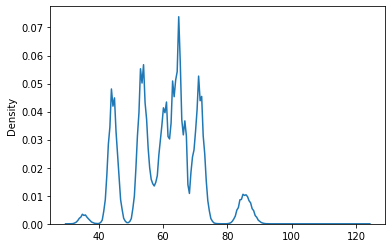

In [8]:
sns.kdeplot(lenghts['length'])